In [1]:
import pandas as pd
import numpy as np

import torch
from torch import nn 
from torch.utils.data import DataLoader     # 데이터로더는 데이터셋을 iterable하게 감싸는 역할

from torchvision import datasets            # 데이터셋은 샘플과 정답을 저장함
from torchvision.transforms import ToTensor

import clip

from PIL import Image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

## Our Model

In [3]:
import deeplake
from torchvision import transforms, models

ds_train = deeplake.load('hub://activeloop/pacs-train')
ds_test = deeplake.load('hub://activeloop/pacs-test')

c:\Users\alllh\anaconda3\envs\dev\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.2.9) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


hub://activeloop/pacs-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train
hub://activeloop/pacs-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-test


In [4]:
batch_size = 8

tform = transforms.Compose([
    transforms.RandomRotation(20), # Image augmentation
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    # transforms.Normalize([0.5], [0.5]),
])

train_loader = ds_train.pytorch(num_workers = 0, shuffle = True, 
                                transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})
test_loader = ds_test.pytorch(num_workers = 0, transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})

In [5]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    plt.figure(figsize=(10, 100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.show()

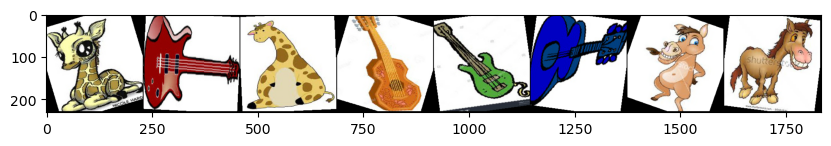

torch.Size([8, 3, 227, 227])


In [6]:
images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images, nrow=8))
print(images.shape)

In [7]:
# image data -> iamge_features
# class data -> class_features  (fixed!)
# label data 
# image sim class -> label

def get_image_features(clip_model, images):
    num_image_layer = clip_model.visual.transformer.layers
    images = images.to(device)

    out_list = []
    x = clip_model.visual.conv1(images.type(clip_model.dtype))
    x = x.reshape(x.shape[0], x.shape[1], -1)   # shape = [*, width, grid ** 2]
    x = x.permute(0, 2, 1)                      # shape = [*, grid ** 2, width]
    x = torch.cat([clip_model.visual.class_embedding.to(x.dtype) + 
                   torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
    x = x + clip_model.visual.positional_embedding.to(x.dtype)
    x = clip_model.visual.ln_pre(x)
    x = x.permute(1, 0, 2)          # NLD -> LND

    for i in range(num_image_layer):
        x = clip_model.visual.transformer.resblocks[i](x)
        tmp = x.permute(1, 0, 2)    # LND -> NLD
        tmp = tmp[:, 0, :].detach()
        out_list.append(tmp)

    image_features = torch.stack(out_list)

    return image_features

def get_text_features(clip_model, texts):
    num_text_layer = clip_model.transformer.layers
    texts = texts.to(device)

    out_list = []
    x = clip_model.token_embedding(texts).type(clip_model.dtype)  # [batch_size, n_ctx, d_clip_model]
    x = x + clip_model.positional_embedding.type(clip_model.dtype)
    x = x.permute(1, 0, 2)                  # NLD -> LND

    for i in range(num_text_layer):
        x = clip_model.transformer.resblocks[i](x)
        tmp = x.permute(1, 0, 2).detach()   # LND -> NLD
        out_list.append(tmp)

    text_features = torch.stack(out_list)

    return text_features

In [8]:
image_features = get_image_features(clip_model, images)
image_features.shape

torch.Size([12, 8, 768])

In [9]:
pacs_class = [
    'a dog', 'an elephant', 'a giraffe', 'a guitar', 'a horse', 'a house', 'a person'
]

def prompt(idx):
    return f"An image of {pacs_class[idx]}"

prompts = [prompt(x) for x in range(7)]
class_tokens = clip.tokenize([prompt(x) for x in range(7)]).to(device)
print(prompts)

['An image of a dog', 'An image of an elephant', 'An image of a giraffe', 'An image of a guitar', 'An image of a horse', 'An image of a house', 'An image of a person']


In [10]:
class_features = get_text_features(clip_model, class_tokens)
class_features.shape

torch.Size([12, 7, 77, 512])

#### inference

In [23]:
image_features2 = clip_model.visual.ln_post(image_features)                   # (12, batch_size, 768)
image_embeddings = image_features2 @ clip_model.visual.proj      # (12, batch_size, 512)  <- we'll use it

class_features2 = clip_model.ln_final(class_features).type(clip_model.dtype)   # (12, seq_len, 77, 512)
class_embeddings = class_features2[:, torch.arange(class_features2.shape[1]), class_tokens.argmax(dim=-1)] @ clip_model.text_projection
                                                                # (12, seq_len, 512)  <- we'll use it

score_tensor = torch.einsum("ijk,mnk->jnim",image_embeddings, class_embeddings)
score_tensor = score_tensor.reshape(*score_tensor.shape[:2],-1)


In [101]:
### score test
score_tensor = torch.einsum("ijk,mnk->jnim",image_embeddings, class_embeddings)
score_tensor = score_tensor.reshape(*score_tensor.shape[:2],-1)

## score 1
# torch.max(score_tensor, dim=-1)[0]

## score 2
torch.mean(score_tensor, dim=-1)

## score 3
# torch.sum(torch.sigmoid(100 * score_tensor.clone().normal_()), dim=-1)
# torch.softmax(score_tensor, dim=-1).exp().sum(dim=-1)
# torch.sigmoid(100 * score_tensor.clone().normal_()).sum(dim=-1)
# score_tensor.clone().min(), score_tensor.clone().max()
# (score_tensor>20).sum(dim=-1)
# x = torch.sigmoid((score_tensor-20)*1000)
# x.sum(dim=-1), (score_tensor>20).sum(dim=-1)

## score 4 : 이미지의 각 레이어에 대해 가장 높은 연관성을 보이는 텍스트 레이어를 찾고 활용히기
score_tensor = torch.einsum("ijk,mnk->jnim",image_embeddings, class_embeddings)
score_tensor.max(dim=-1)[0].mean(dim=-1)

tensor([[343.7500, 286.2500, 281.7500, 264.7500, 349.2500, 323.0000, 387.5000],
        [346.0000, 285.7500, 277.5000, 289.5000, 351.0000, 328.5000, 393.0000],
        [351.0000, 288.5000, 287.0000, 268.7500, 354.7500, 326.0000, 393.7500],
        [347.0000, 288.0000, 280.5000, 290.0000, 350.2500, 332.2500, 396.0000],
        [347.7500, 288.0000, 278.0000, 286.0000, 352.0000, 331.5000, 393.5000],
        [347.0000, 289.5000, 277.2500, 289.2500, 349.7500, 330.2500, 395.0000],
        [348.7500, 285.5000, 278.7500, 264.0000, 352.7500, 323.0000, 394.5000],
        [344.5000, 283.2500, 274.0000, 262.5000, 357.2500, 324.2500, 391.0000]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SumBackward1>)

In [148]:
# torch.tanh(torch.randn_like(clip_model.visual.proj, dtype=torch.float16)).max()
# clip_model.visual.proj.min(), clip_model.visual.proj.max()
# (torch.randn_like(clip_model.visual.proj, dtype=torch.float16, requires_grad=True)/50)
# torch.rand_like(clip_model.text_projection, dtype=torch.float16).min(), torch.rand_like(clip_model.text_projection, dtype=torch.float16).max()
# clip_model.text_projection.min(), clip_model.text_projection.max()
(torch.rand_like(clip_model.visual.proj, dtype=torch.float16)/5-0.1).max()

tensor(0.1000, device='cuda:0', dtype=torch.float16)

In [151]:
# Define model
class OurCLIP(nn.Module):        
    def __init__(self, clip_model, # use pre-trained clip model
                 use_one_ln1=True, use_one_ln2=True, 
                 use_one_projection1=True, use_one_projection2=True,
                 projection_random_init1=False, 
                 projection_random_init2=False, 
                 trainable_ln1=False, trainable_ln2=False, 
                 trainable_projection1=False, trainable_projection2=False,
                 threshold = 20, score_type=0): 
        super().__init__()

        self.dtype = clip_model.dtype
        self.threshold = threshold
        self.score_type = score_type

        ####################### 미구현
        if use_one_ln1:
            self.ln_post = clip_model.visual.ln_post.requires_grad_(trainable_ln1)
        else: pass
        if use_one_ln2:
            self.ln_final = clip_model.ln_final.requires_grad_(trainable_ln2)
        else: pass
        ########################

        if use_one_projection1:
            self.visual_projection = nn.Parameter(clip_model.visual.proj.clone().detach()).requires_grad_(trainable_projection1)
        else:
            if projection_random_init1:
                self.visual_projection = nn.Parameter(
                    torch.stack([
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        clip_model.visual.proj.clone().detach()
                    ])).requires_grad_(trainable_projection1)
            else:
                self.visual_projection = nn.Parameter(
                    torch.stack([
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach()
                    ])).requires_grad_(trainable_projection1)
        
        if use_one_projection2:
            self.textual_projection = nn.Parameter(clip_model.text_projection.clone().detach()).requires_grad_(trainable_projection2)
        else:
            if projection_random_init2:
                self.textual_projection = nn.Parameter(
                    torch.stack([
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        clip_model.text_projection.clone().detach()
                    ])).requires_grad_(trainable_projection2)
            else:
                self.textual_projection = nn.Parameter(
                    torch.stack([
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach()
                    ])).requires_grad_(trainable_projection2)


    def forward(self, image_features, class_features, class_tokens):    
        image_features2 = self.ln_post(image_features)                      # (12, batch_size, 768)
        image_embeddings = image_features2 @ self.visual_projection         # (12, batch_size, 512)  <- we'll use it

        class_features2 = self.ln_final(class_features).type(self.dtype)    # (12, seq_len, 77, 512)
        class_embeddings = class_features2[:, torch.arange(class_features2.shape[1]), 
                                           class_tokens.argmax(dim=-1)] @ self.textual_projection
                                                                            # (12, seq_len, 512)  <- we'll use it

        score_tensor = torch.einsum("ijk,mnk->jnim",image_embeddings, class_embeddings)
        if self.score_type != 3:
            score_tensor = score_tensor.reshape(*score_tensor.shape[:2],-1)

        if self.score_type == 1:
            return torch.mean(score_tensor, dim=-1)
        if self.score_type == 2:
            return torch.sigmoid(100 * (score_tensor-self.threshold)).sum(dim=-1)
        if self.score_type == 3:
            return score_tensor.max(dim=-1)[0].mean(dim=-1)
        return torch.max(score_tensor, dim=-1)[0]

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

model = OurCLIP(clip_model, trainable_projection1=True, trainable_projection2=True).to(device)  # model을 initialize하는 부분
print(model)

OurCLIP(
  (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (ln_final): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)


In [16]:
for name, param in model.named_parameters():
    print(name, param.shape)

visual_projection torch.Size([768, 512])
textual_projection torch.Size([512, 512])
ln_post.weight torch.Size([768])
ln_post.bias torch.Size([768])
ln_final.weight torch.Size([512])
ln_final.bias torch.Size([512])


## Train

In [17]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1) # momentum

In [122]:
import time
import torch.nn.functional as f

def train_one_epoch(clip_model, model, optimizer, data_loader, device, max_iter_num=3000):

    model.train()

    # Zero the performance stats for each epoch
    running_loss = 0.0
    start_time = time.time()
    total = 0
    correct = 0
    
    for i, data in enumerate(data_loader):
        images = data['images']
        labels = torch.squeeze(data['labels'])

        images = images.to(device)
        labels = labels.to(device)

        image_features = get_image_features(clip_model, images)
        
        optimizer.zero_grad()
        
        output = model(image_features, class_features, class_tokens)

        # normalize
        # output = f.normalize(output)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.argmax(output, dim=-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
        # Print performance statistics
        running_loss += loss.item()
        if i != 0 and i % 10 == 0:    # print every 10 batches
            batch_time = time.time()
            speed = (i+1)/(batch_time-start_time)
            print('[%5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                  (i, running_loss, speed, accuracy))

            running_loss = 0.0
            total = 0
            correct = 0
        if i != 0 and i % max_iter_num == 0:
            break;

    
def test_model(clip_model, model, data_loader, max_iter_num=1000):

    model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # get the images; data is a list of [images, labels]
            images = data['images']
            labels = torch.squeeze(data['labels'])

            images = images.to(device)
            labels = labels.to(device)

            image_features = get_image_features(clip_model, images)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = model(image_features, class_features, class_tokens)

            predicted = torch.argmax(output, dim=-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
            if i != 0 and i % max_iter_num == 0:
                break
        accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))
    return accuracy

### inference

In [114]:
batch_size = 32

train_loader = ds_train.pytorch(num_workers = 0, shuffle = True, 
                                transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})
test_loader = ds_test.pytorch(num_workers = 0, transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})

In [161]:
# train all by one tensor / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 6

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)
    accuracy = test_model(clip_model, model, test_loader)
    with open("output0227.txt", 'a') as f:
        f.write("="*10+"train all by one tensor / max_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")


print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 1.645, speed: 0.60, accuracy: 94.32 %
[   20] loss: 0.254, speed: 0.87, accuracy: 99.38 %
[   30] loss: 1.362, speed: 0.90, accuracy: 95.94 %
[   40] loss: 0.427, speed: 1.02, accuracy: 99.06 %
[   50] loss: 0.912, speed: 0.99, accuracy: 96.88 %
[   60] loss: 0.903, speed: 1.05, accuracy: 96.88 %
[   70] loss: 1.355, speed: 1.02, accuracy: 94.69 %
[   80] loss: 0.479, speed: 1.07, accuracy: 99.06 %
[   90] loss: 1.028, speed: 1.03, accuracy: 96.25 %
[  100] loss: 0.335, speed: 1.07, accuracy: 98.75 %
[  110] loss: 0.093, speed: 1.10, accuracy: 100.00 %
[  120] loss: 0.250, speed: 1.13, accuracy: 99.69 %
[  130] loss: 6.623, speed: 1.10, accuracy: 80.94 %
[  140] loss: 2.660, speed: 1.12, accuracy: 90.00 %
[  150] loss: 1.827, speed: 1.15, accuracy: 93.75 %
[  160] loss: 1.314, speed: 1.17, accuracy: 96.56 %
[  170] loss: 3.154, speed: 1.19, accuracy: 88.44 %
[  180] loss: 2.082, speed: 1.21, accuracy: 92.81 %
[  190] 

In [162]:
# train all by one tensor / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=1).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 6

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)
    accuracy = test_model(clip_model, model, test_loader)
    with open("output0227.txt", 'a') as f:
        f.write("="*10+"train all by one tensor / mean_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")


print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 8.167, speed: 0.20, accuracy: 76.70 %
[   20] loss: 7.292, speed: 0.35, accuracy: 84.69 %
[   30] loss: 5.505, speed: 0.47, accuracy: 91.25 %
[   40] loss: 11.132, speed: 0.37, accuracy: 73.44 %
[   50] loss: 11.899, speed: 0.43, accuracy: 67.81 %
[   60] loss: 12.458, speed: 0.37, accuracy: 63.12 %
[   70] loss: 15.568, speed: 0.42, accuracy: 36.25 %
[   80] loss: 14.352, speed: 0.46, accuracy: 52.50 %
[   90] loss: 14.588, speed: 0.50, accuracy: 48.75 %
[  100] loss: 13.656, speed: 0.54, accuracy: 48.44 %
[  110] loss: 13.992, speed: 0.58, accuracy: 57.50 %
[  120] loss: 13.929, speed: 0.61, accuracy: 55.31 %
[  130] loss: 14.779, speed: 0.65, accuracy: 54.38 %
[  140] loss: 13.620, speed: 0.67, accuracy: 58.44 %
[  150] loss: 15.278, speed: 0.58, accuracy: 44.06 %
[  160] loss: 10.940, speed: 0.60, accuracy: 58.75 %
[  170] loss: 13.600, speed: 0.53, accuracy: 53.12 %
[  180] loss: 12.772, speed: 0.55, accuracy: 57

In [163]:
# train all by one tensor / count_score 
# reference: https://discuss.pytorch.org/t/is-there-any-soft-way-of-counting-positive-values-with-grad-reserved/158975/2
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=2).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 1

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)
    accuracy = test_model(clip_model, model, test_loader)
    with open("output0227.txt", 'a') as f:
        f.write("="*10+"train all by one tensor / count_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 25.697, speed: 0.64, accuracy: 36.93 %
[   20] loss: 19.463, speed: 0.92, accuracy: 40.00 %
[   30] loss: 19.463, speed: 0.93, accuracy: 45.00 %
[   40] loss: 19.463, speed: 1.05, accuracy: 49.69 %
[   50] loss: 19.463, speed: 1.03, accuracy: 32.81 %
[   60] loss: 19.463, speed: 1.11, accuracy: 0.00 %
[   70] loss: 19.463, speed: 1.17, accuracy: 0.00 %
[   80] loss: 19.463, speed: 1.13, accuracy: 0.62 %
[   90] loss: 19.463, speed: 1.18, accuracy: 0.62 %
[  100] loss: 19.463, speed: 1.22, accuracy: 0.62 %
[  110] loss: 19.463, speed: 1.25, accuracy: 0.62 %
[  120] loss: 19.463, speed: 1.29, accuracy: 1.25 %
[  130] loss: 19.463, speed: 1.31, accuracy: 1.25 %
[  140] loss: 19.463, speed: 1.34, accuracy: 0.62 %
[  150] loss: 19.463, speed: 1.36, accuracy: 0.94 %
[  160] loss: 19.463, speed: 1.38, accuracy: 0.62 %
[  170] loss: 19.463, speed: 1.35, accuracy: 0.00 %
[  180] loss: 19.463, speed: 1.37, accuracy: 0.00 %
[  1

In [164]:
# train all by one tensor / new_score
# reference: https://discuss.pytorch.org/t/is-there-any-soft-way-of-counting-positive-values-with-grad-reserved/158975/2
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=3).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 6

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)
    accuracy = test_model(clip_model, model, test_loader)
    with open("output0227.txt", 'a') as f:
        f.write("="*10+"train all by one tensor / new_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 49.644, speed: 0.66, accuracy: 38.64 %
[   20] loss: 18.874, speed: 0.94, accuracy: 55.31 %
[   30] loss: 12.954, speed: 0.98, accuracy: 65.31 %
[   40] loss: 16.898, speed: 0.99, accuracy: 53.12 %
[   50] loss: 17.480, speed: 1.08, accuracy: 51.25 %
[   60] loss: 11.716, speed: 1.14, accuracy: 55.31 %
[   70] loss: 13.878, speed: 1.13, accuracy: 55.94 %
[   80] loss: 3.880, speed: 1.18, accuracy: 91.88 %
[   90] loss: 2.100, speed: 1.22, accuracy: 98.75 %
[  100] loss: 2.171, speed: 1.25, accuracy: 97.50 %
[  110] loss: 7.856, speed: 1.23, accuracy: 81.56 %
[  120] loss: 5.406, speed: 1.26, accuracy: 96.25 %
[  130] loss: 6.036, speed: 1.24, accuracy: 85.31 %
[  140] loss: 6.605, speed: 1.27, accuracy: 81.25 %
[  150] loss: 5.626, speed: 1.29, accuracy: 86.88 %
[  160] loss: 11.797, speed: 1.27, accuracy: 61.25 %
[  170] loss: 7.924, speed: 1.29, accuracy: 67.19 %
[  180] loss: 9.718, speed: 1.28, accuracy: 69.38 %
[

In [165]:
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)  # model을 initialize하는 부분
# (image_features2 @ model.visual_projection).shape
image_features2.shape, model.visual_projection.shape

(torch.Size([12, 8, 768]), torch.Size([12, 768, 512]))

In [166]:
# train all by each tensor(init with last weight) / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 6

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)
    accuracy = test_model(clip_model, model, test_loader)
    with open("output0227.txt", 'a') as f:
        f.write("="*10+"train all by each tensor(init with last weight) / max_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")
print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 1.152, speed: 0.62, accuracy: 97.44 %
[   20] loss: 0.525, speed: 0.71, accuracy: 98.44 %
[   30] loss: 0.423, speed: 0.88, accuracy: 97.50 %
[   40] loss: 0.329, speed: 0.89, accuracy: 99.06 %
[   50] loss: 0.790, speed: 0.98, accuracy: 97.50 %
[   60] loss: 0.446, speed: 1.06, accuracy: 98.44 %
[   70] loss: 3.415, speed: 1.06, accuracy: 89.06 %
[   80] loss: 2.169, speed: 1.12, accuracy: 93.12 %
[   90] loss: 1.772, speed: 1.16, accuracy: 93.44 %
[  100] loss: 4.429, speed: 1.21, accuracy: 85.31 %
[  110] loss: 2.104, speed: 1.24, accuracy: 92.81 %
[  120] loss: 1.972, speed: 1.27, accuracy: 90.94 %
[  130] loss: 1.920, speed: 1.30, accuracy: 92.19 %
[  140] loss: 1.530, speed: 1.33, accuracy: 94.69 %
[  150] loss: 2.261, speed: 1.35, accuracy: 90.62 %
[  160] loss: 2.127, speed: 1.33, accuracy: 92.19 %
[  170] loss: 0.694, speed: 1.35, accuracy: 97.50 %
[  180] loss: 1.928, speed: 1.33, accuracy: 93.44 %
[  190] l

In [167]:
# 의도한 대로 학습되었는지 확인하기
model.visual_projection[0], model.visual_projection[1]

(tensor([[-2.6264e-03,  4.9770e-05,  2.7496e-02,  ..., -1.0025e-02,
          -1.2222e-02,  5.8403e-03],
         [-1.9852e-02,  7.1220e-03,  8.9788e-04,  ...,  1.1520e-02,
          -1.9485e-02, -8.0185e-03],
         [-8.6288e-03,  1.9217e-03, -2.1725e-03,  ...,  3.9368e-03,
          -1.1269e-02,  1.5354e-03],
         ...,
         [-1.1993e-02,  1.2955e-02,  2.5848e-02,  ..., -9.8038e-03,
          -4.2076e-03,  1.5235e-04],
         [-1.2871e-02, -9.5673e-03, -1.0826e-02,  ..., -7.0572e-03,
          -4.3182e-03, -4.9305e-04],
         [-4.4098e-03,  3.3588e-03, -1.2054e-02,  ...,  6.1073e-03,
           3.9940e-03, -3.0861e-03]], device='cuda:0', dtype=torch.float16,
        grad_fn=<SelectBackward0>),
 tensor([[-2.6264e-03,  5.0426e-05,  2.7496e-02,  ..., -1.0025e-02,
          -1.2222e-02,  5.8403e-03],
         [-1.9852e-02,  7.1182e-03,  8.9788e-04,  ...,  1.1528e-02,
          -1.9485e-02, -8.0185e-03],
         [-8.6288e-03,  1.9217e-03, -2.1725e-03,  ...,  3.9330e-03,
   

In [168]:
# train all by each tensor(init with last weight) / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=1).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 6

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)
    accuracy = test_model(clip_model, model, test_loader)
    with open("output0227.txt", 'a') as f:
        f.write("="*10+"train all by each tensor(init with last weight) / mean_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")
print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 22.302, speed: 0.65, accuracy: 36.65 %
[   20] loss: 13.133, speed: 0.75, accuracy: 51.25 %
[   30] loss: 9.518, speed: 0.92, accuracy: 62.50 %
[   40] loss: 8.215, speed: 1.05, accuracy: 79.69 %
[   50] loss: 7.752, speed: 1.14, accuracy: 86.88 %
[   60] loss: 9.599, speed: 1.08, accuracy: 70.00 %
[   70] loss: 11.562, speed: 1.14, accuracy: 65.62 %
[   80] loss: 13.609, speed: 1.11, accuracy: 39.69 %
[   90] loss: 20.687, speed: 1.15, accuracy: 20.00 %
[  100] loss: 16.575, speed: 1.20, accuracy: 26.56 %
[  110] loss: 15.609, speed: 1.23, accuracy: 40.00 %
[  120] loss: 15.006, speed: 1.27, accuracy: 50.62 %
[  130] loss: 15.153, speed: 1.29, accuracy: 55.62 %
[  140] loss: 14.853, speed: 1.32, accuracy: 46.56 %
[  150] loss: 14.650, speed: 1.34, accuracy: 56.56 %
[  160] loss: 14.074, speed: 1.36, accuracy: 67.19 %
[  170] loss: 14.481, speed: 1.33, accuracy: 69.38 %
[  180] loss: 12.708, speed: 1.35, accuracy: 82.

In [169]:
# train all by each tensor(init with last weight) / count_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=2).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 1

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)
    accuracy = test_model(clip_model, model, test_loader)
    with open("output0227.txt", 'a') as f:
        f.write("="*10+"train all by each tensor(init with last weight) / count_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 30.423, speed: 0.62, accuracy: 7.95 %
[   20] loss: 21.186, speed: 0.90, accuracy: 4.06 %
[   30] loss: 21.113, speed: 1.07, accuracy: 4.38 %
[   40] loss: 20.996, speed: 1.19, accuracy: 4.69 %
[   50] loss: 21.531, speed: 1.27, accuracy: 1.25 %
[   60] loss: 21.410, speed: 1.33, accuracy: 2.50 %
[   70] loss: 21.410, speed: 1.38, accuracy: 2.50 %
[   80] loss: 21.504, speed: 1.42, accuracy: 1.56 %
[   90] loss: 20.782, speed: 1.38, accuracy: 8.75 %
[  100] loss: 18.759, speed: 1.42, accuracy: 30.31 %
[  110] loss: 18.660, speed: 1.44, accuracy: 30.00 %
[  120] loss: 20.002, speed: 1.40, accuracy: 16.56 %
[  130] loss: 20.957, speed: 1.42, accuracy: 1.56 %
[  140] loss: 20.648, speed: 1.40, accuracy: 8.44 %
[  150] loss: 18.968, speed: 1.41, accuracy: 26.25 %
[  160] loss: 19.798, speed: 1.39, accuracy: 18.44 %
[  170] loss: 19.998, speed: 1.41, accuracy: 16.88 %
[  180] loss: 19.879, speed: 1.39, accuracy: 17.81 %
[ 

In [170]:
# train all by each tensor(init with last weight) / new_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=3).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 6

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)
    accuracy = test_model(clip_model, model, test_loader)
    with open("output0227.txt", 'a') as f:
        f.write("="*10+"train all by each tensor(init with last weight) / new_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 30.833, speed: 0.56, accuracy: 45.17 %
[   20] loss: 37.928, speed: 0.72, accuracy: 35.94 %
[   30] loss: 13.749, speed: 0.89, accuracy: 47.81 %
[   40] loss: 9.207, speed: 1.02, accuracy: 66.88 %
[   50] loss: 21.193, speed: 1.03, accuracy: 26.56 %
[   60] loss: 12.770, speed: 1.11, accuracy: 54.06 %
[   70] loss: 15.852, speed: 1.17, accuracy: 34.69 %
[   80] loss: 13.244, speed: 1.22, accuracy: 52.50 %
[   90] loss: 12.784, speed: 1.27, accuracy: 54.06 %
[  100] loss: 13.298, speed: 1.31, accuracy: 43.75 %
[  110] loss: 12.386, speed: 1.34, accuracy: 53.44 %
[  120] loss: 12.302, speed: 1.37, accuracy: 46.56 %
[  130] loss: 13.353, speed: 1.33, accuracy: 46.56 %
[  140] loss: 11.219, speed: 1.35, accuracy: 63.12 %
[  150] loss: 14.150, speed: 1.33, accuracy: 60.00 %
[  160] loss: 8.421, speed: 1.35, accuracy: 66.88 %
[  170] loss: 11.720, speed: 1.34, accuracy: 49.06 %
[  180] loss: 9.306, speed: 1.35, accuracy: 73

In [171]:
# train all by each tensor(init with randn weight) / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=0).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 6

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)
    accuracy = test_model(clip_model, model, test_loader)
    with open("output0227.txt", 'a') as f:
        f.write("="*10+"train all by each tensor(init with randn weight) / max_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 1.449, speed: 0.54, accuracy: 97.16 %
[   20] loss: 0.600, speed: 0.81, accuracy: 97.50 %
[   30] loss: 1.079, speed: 0.83, accuracy: 96.88 %
[   40] loss: 0.888, speed: 0.95, accuracy: 97.50 %
[   50] loss: 1.462, speed: 0.94, accuracy: 95.31 %
[   60] loss: 1.056, speed: 1.02, accuracy: 97.19 %
[   70] loss: 1.676, speed: 1.02, accuracy: 91.88 %
[   80] loss: 0.352, speed: 1.07, accuracy: 98.75 %
[   90] loss: 0.507, speed: 1.07, accuracy: 98.44 %
[  100] loss: 0.420, speed: 1.11, accuracy: 99.06 %
[  110] loss: 1.131, speed: 1.10, accuracy: 96.25 %
[  120] loss: 2.483, speed: 1.14, accuracy: 92.19 %
[  130] loss: 2.413, speed: 1.17, accuracy: 91.25 %
[  140] loss: 2.812, speed: 1.20, accuracy: 89.38 %
[  150] loss: 3.138, speed: 1.23, accuracy: 90.62 %
[  160] loss: 1.999, speed: 1.25, accuracy: 91.88 %
[  170] loss: 1.690, speed: 1.27, accuracy: 93.12 %
[  180] loss: 3.633, speed: 1.29, accuracy: 91.56 %
[  190] l

In [172]:
model.visual_projection, clip_model.visual.proj

(Parameter containing:
 tensor([[[ 2.2903e-02,  8.4152e-03, -1.7593e-02,  ..., -3.6068e-03,
           -2.2614e-02, -2.2415e-02],
          [-1.7868e-02,  7.3891e-03, -3.0609e-02,  ..., -1.8021e-02,
           -3.2471e-02,  1.7670e-02],
          [ 7.2136e-03, -2.0935e-02, -1.4206e-02,  ..., -2.5742e-02,
           -2.0782e-02,  2.0447e-02],
          ...,
          [ 1.6174e-02,  2.9877e-02, -3.5614e-02,  ..., -1.3565e-02,
            2.0203e-02,  2.3361e-02],
          [-1.1337e-02, -7.3624e-03, -6.5041e-03,  ..., -2.9800e-02,
           -1.5625e-02, -7.2937e-03],
          [ 5.8022e-03, -6.4201e-03, -2.1408e-02,  ...,  2.8591e-03,
           -3.4210e-02, -1.6088e-03]],
 
         [[ 1.3161e-02, -6.3248e-03, -1.0078e-02,  ..., -2.6978e-02,
            1.5228e-02,  2.4551e-02],
          [-1.0460e-02, -2.4475e-02, -3.0121e-02,  ..., -1.1063e-02,
           -7.7677e-04, -1.5175e-02],
          [-4.0855e-03,  2.5139e-03,  3.3356e-02,  ...,  2.6291e-02,
           -3.0457e-02,  1.6159e-0

In [173]:
# train all by each tensor(init with randn weight) / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=1).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 6

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)
    accuracy = test_model(clip_model, model, test_loader)
    with open("output0227.txt", 'a') as f:
        f.write("="*10+"train all by each tensor(init with randn weight) / mean_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 20.396, speed: 0.70, accuracy: 48.86 %
[   20] loss: 17.103, speed: 0.98, accuracy: 47.81 %
[   30] loss: 19.944, speed: 1.02, accuracy: 6.56 %
[   40] loss: 19.450, speed: 1.13, accuracy: 2.19 %
[   50] loss: 19.187, speed: 1.11, accuracy: 10.94 %
[   60] loss: 18.989, speed: 1.18, accuracy: 32.81 %
[   70] loss: 18.132, speed: 1.24, accuracy: 45.31 %
[   80] loss: 17.832, speed: 1.22, accuracy: 59.06 %
[   90] loss: 18.446, speed: 1.26, accuracy: 24.06 %
[  100] loss: 18.111, speed: 1.30, accuracy: 28.75 %
[  110] loss: 17.628, speed: 1.33, accuracy: 41.56 %
[  120] loss: 17.971, speed: 1.36, accuracy: 39.69 %
[  130] loss: 17.454, speed: 1.39, accuracy: 39.38 %
[  140] loss: 17.491, speed: 1.41, accuracy: 40.31 %
[  150] loss: 17.550, speed: 1.43, accuracy: 36.88 %
[  160] loss: 17.223, speed: 1.45, accuracy: 42.19 %
[  170] loss: 17.452, speed: 1.41, accuracy: 37.50 %
[  180] loss: 17.725, speed: 1.43, accuracy: 3

In [174]:
# train all by each tensor(init with randn weight) / count_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=2).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 1

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)
    accuracy = test_model(clip_model, model, test_loader)
    with open("output0227.txt", 'a') as f:
        f.write("="*10+"train all by each tensor(init with randn weight) / count_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 20.657, speed: 0.62, accuracy: 4.26 %
[   20] loss: 19.562, speed: 0.73, accuracy: 0.31 %
[   30] loss: 19.511, speed: 0.90, accuracy: 0.94 %
[   40] loss: 19.463, speed: 1.02, accuracy: 0.94 %
[   50] loss: 19.463, speed: 1.12, accuracy: 0.31 %
[   60] loss: 19.463, speed: 1.19, accuracy: 1.25 %
[   70] loss: 19.463, speed: 1.25, accuracy: 0.62 %
[   80] loss: 19.463, speed: 1.30, accuracy: 0.62 %
[   90] loss: 19.463, speed: 1.34, accuracy: 0.62 %
[  100] loss: 19.463, speed: 1.37, accuracy: 1.25 %
[  110] loss: 19.463, speed: 1.29, accuracy: 22.81 %
[  120] loss: 19.449, speed: 1.32, accuracy: 49.38 %
[  130] loss: 19.464, speed: 1.25, accuracy: 27.50 %
[  140] loss: 19.463, speed: 1.28, accuracy: 0.00 %
[  150] loss: 19.457, speed: 1.24, accuracy: 30.94 %
[  160] loss: 19.463, speed: 1.27, accuracy: 58.75 %
[  170] loss: 19.457, speed: 1.29, accuracy: 55.31 %
[  180] loss: 19.463, speed: 1.31, accuracy: 56.25 %
[ 

In [175]:
# train all by each tensor(init with randn weight) / new_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=3).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 6

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(clip_model, model, optimizer, train_loader, device, max_iter_num=1000)
    accuracy = test_model(clip_model, model, test_loader)
    with open("output0227.txt", 'a') as f:
        f.write("="*10+"train all by each tensor(init with randn weight) / new_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 12.238, speed: 0.58, accuracy: 92.90 %
[   20] loss: 10.185, speed: 0.69, accuracy: 90.62 %
[   30] loss: 9.095, speed: 0.86, accuracy: 81.88 %
[   40] loss: 4.688, speed: 0.98, accuracy: 98.44 %
[   50] loss: 3.426, speed: 1.08, accuracy: 98.75 %
[   60] loss: 8.705, speed: 1.04, accuracy: 80.00 %
[   70] loss: 9.307, speed: 1.11, accuracy: 75.62 %
[   80] loss: 7.401, speed: 1.16, accuracy: 91.56 %
[   90] loss: 10.333, speed: 1.12, accuracy: 70.94 %
[  100] loss: 7.064, speed: 1.16, accuracy: 84.06 %
[  110] loss: 7.302, speed: 1.13, accuracy: 84.38 %
[  120] loss: 7.133, speed: 1.17, accuracy: 85.62 %
[  130] loss: 12.290, speed: 1.14, accuracy: 58.44 %
[  140] loss: 14.391, speed: 1.17, accuracy: 50.31 %
[  150] loss: 11.574, speed: 1.20, accuracy: 72.50 %
[  160] loss: 11.024, speed: 1.23, accuracy: 85.00 %
[  170] loss: 10.006, speed: 1.25, accuracy: 87.19 %
[  180] loss: 10.693, speed: 1.27, accuracy: 80.94 %


In [176]:
# non_train / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=False, trainable_projection2=False,
                score_type=0).to(device)  # model을 initialize하는 부분

accuracy = test_model(clip_model, model, test_loader)
with open("output0227.txt", 'a') as f:
    f.write("="*10+"non_train / max_score\n")
    f.write(f"accuracy: {accuracy:.4f}\n")


Finished Testing
Testing accuracy: 58.3 %


In [177]:
clip_model.visual.proj, model.visual_projection

(Parameter containing:
 tensor([[-2.6264e-03,  5.0962e-05,  2.7496e-02,  ..., -1.0025e-02,
          -1.2222e-02,  5.8403e-03],
         [-1.9852e-02,  7.1182e-03,  8.9788e-04,  ...,  1.1528e-02,
          -1.9485e-02, -8.0185e-03],
         [-8.6288e-03,  1.9226e-03, -2.1725e-03,  ...,  3.9330e-03,
          -1.1269e-02,  1.5345e-03],
         ...,
         [-1.1993e-02,  1.2955e-02,  2.5848e-02,  ..., -9.8038e-03,
          -4.2076e-03,  1.5211e-04],
         [-1.2871e-02, -9.5673e-03, -1.0826e-02,  ..., -7.0610e-03,
          -4.3182e-03, -4.9353e-04],
         [-4.4098e-03,  3.3588e-03, -1.2054e-02,  ...,  6.1073e-03,
           3.9940e-03, -3.0861e-03]], device='cuda:0', dtype=torch.float16,
        requires_grad=True),
 Parameter containing:
 tensor([[-2.6264e-03,  5.0962e-05,  2.7496e-02,  ..., -1.0025e-02,
          -1.2222e-02,  5.8403e-03],
         [-1.9852e-02,  7.1182e-03,  8.9788e-04,  ...,  1.1528e-02,
          -1.9485e-02, -8.0185e-03],
         [-8.6288e-03,  1.9226e-

In [157]:
# non_train / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=False, trainable_projection2=False,
                score_type=1).to(device)  # model을 initialize하는 부분

accuracy = test_model(clip_model, model, test_loader)
with open("output0227.txt", 'a') as f:
    f.write("="*10+"non_train / mean_score\n")
    f.write(f"accuracy: {accuracy:.4f}\n")


Finished Testing
Testing accuracy: 14.5 %


In [158]:
# non_train / count_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=False, trainable_projection2=False,
                score_type=2).to(device)  # model을 initialize하는 부분

accuracy = test_model(clip_model, model, test_loader)
with open("output0227.txt", 'a') as f:
    f.write("="*10+"non_train / count_score\n")
    f.write(f"accuracy: {accuracy:.4f}\n")


Finished Testing
Testing accuracy: 26.3 %


In [159]:
# zeroshot
def test_model_for_clip_model(clip_model, data_loader, max_iter_num=100):

    clip_model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['images']
            labels = torch.squeeze(data['labels'])
        
            inputs = inputs.to(device)
            labels = labels.to(device)

            # inputs = inputs.permute([0, 3, 1, 2])   # N, H, W, C -> N, C, H, W

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = clip_model(inputs, class_tokens)[0].softmax(dim=-1)
    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if i != 0 and i % max_iter_num == 0:
                break
        accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))

In [160]:
test_model_for_clip_model(clip_model, test_loader)

Finished Testing
Testing accuracy: 93.8 %
